# Spaceship Titanic Competition 2025

In this notebook, I will be predicting transportation status of passengers in order to help mitigate passengers being transported to an alternate dimension. The goal of this exercise is to achieve the highest predictive accuracy possible using ML models and statistics. 

The Process I will follow for this project is as follows: 
* Import dataset and clean
* Perform initial EDA and anomaly detection
* Engineer features for flatter data
* Data Preprocessing
* Model development
* Ensemble and final predictions
* Results summary

## Import Dataset and Clean

A summary of each column from the data tab in Kaggle: 
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
# import dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# import dataset
test_path = 'data/test.csv'
train_path = 'data/train.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Looking at the distribution of the categorical and numerical columns could be insightful going into our analysis as well as for predictive purposes. Going column by column, we'll look at distribution of unique values using bar charts and histograms. 

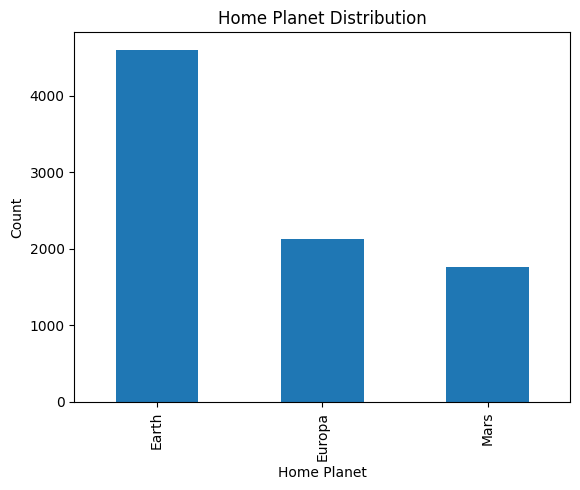

In [2]:
# Home Planet
train_df['HomePlanet'].value_counts().plot(kind='bar', title='Home Planet Distribution')
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.show()


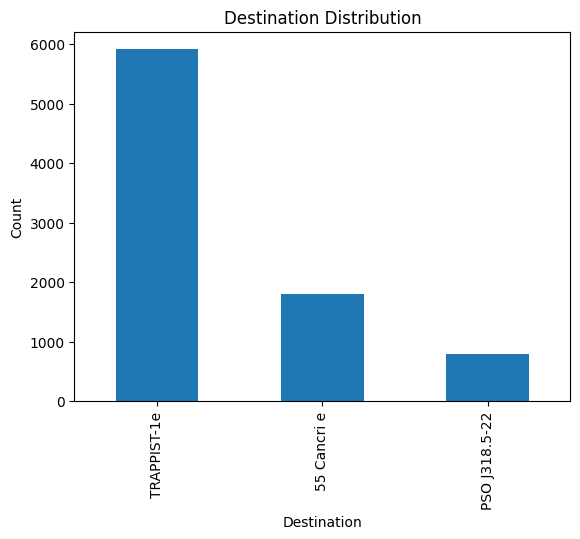

In [3]:
# Destination
train_df['Destination'].value_counts().plot(kind='bar', title='Destination Distribution')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.show()


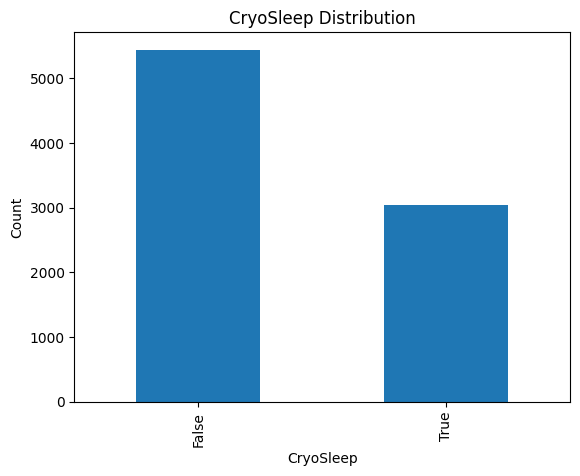

In [4]:
# Cryosleep
train_df['CryoSleep'].value_counts().plot(kind='bar', title='CryoSleep Distribution')
plt.xlabel('CryoSleep')
plt.ylabel('Count')
plt.show()


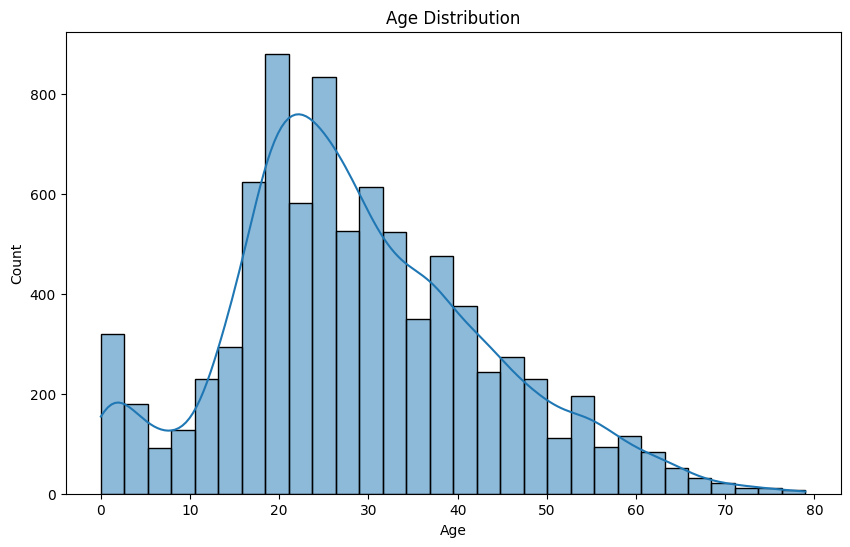

In [5]:
# Age
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


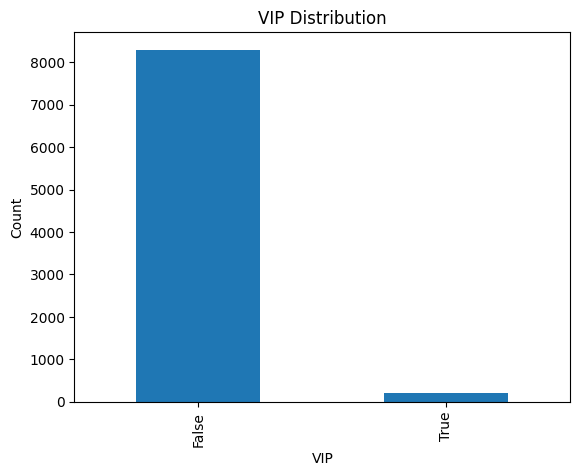

In [6]:
# VIP
train_df['VIP'].value_counts().plot(kind='bar', title='VIP Distribution')
plt.xlabel('VIP')
plt.ylabel('Count')
plt.show()


Very large difference between VIP and non-VIP which could be insightful for prediction, but we will need to see what the proportions are before being able to make that decision. 

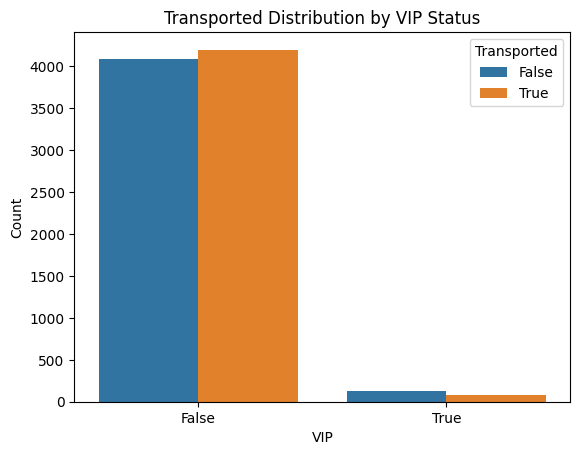

In [7]:
sns.countplot(data=train_df, x='VIP', hue='Transported')
plt.title('Transported Distribution by VIP Status')
plt.xlabel('VIP')
plt.ylabel('Count')
plt.show()

It seems that VIP status does not really matter as both VIP and non-VIP members are near evenly split. 

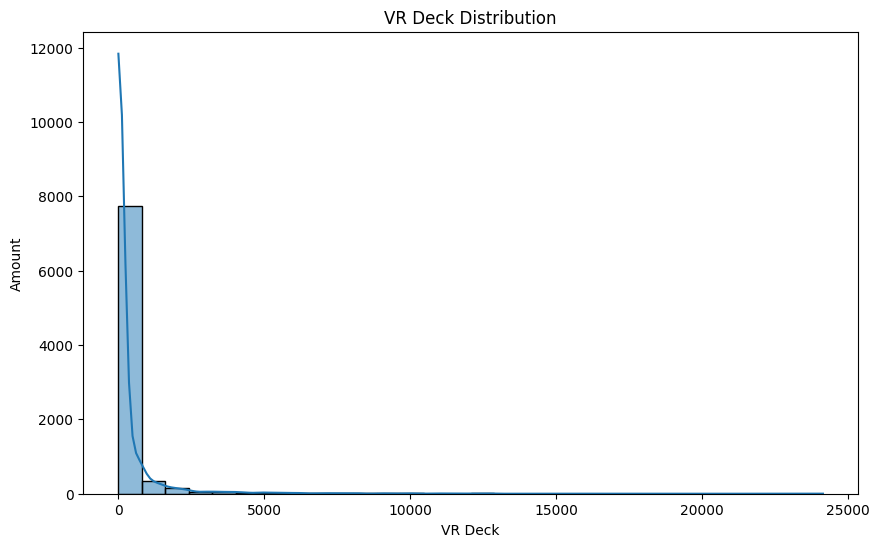

In [8]:
# VR Deck
plt.figure(figsize=(10, 6))
sns.histplot(train_df['VRDeck'].dropna(), bins=30, kde=True)
plt.title('VR Deck Distribution')
plt.xlabel('VR Deck')
plt.ylabel('Amount')
plt.show()


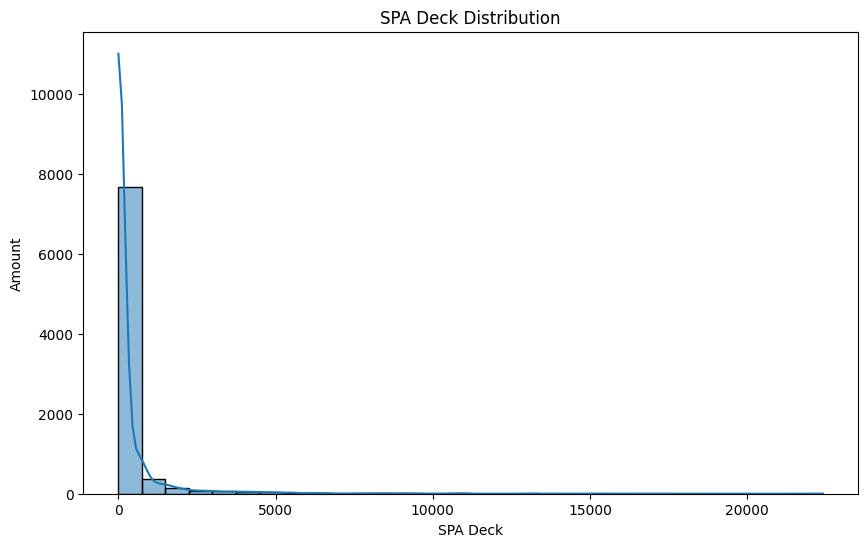

In [9]:
# SPA Deck
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Spa'].dropna(), bins=30, kde=True)
plt.title('SPA Deck Distribution')
plt.xlabel('SPA Deck')
plt.ylabel('Amount')
plt.show()


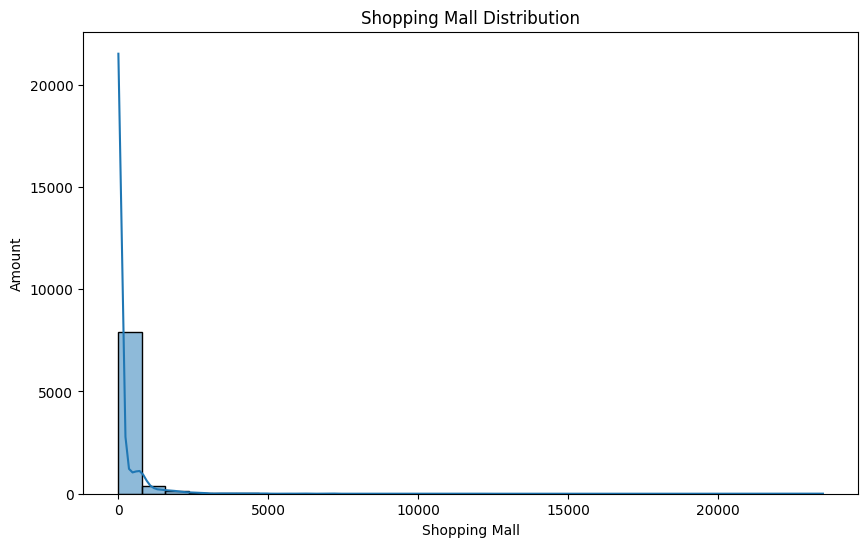

In [10]:
# Shopping Mall
plt.figure(figsize=(10, 6))
sns.histplot(train_df['ShoppingMall'].dropna(), bins=30, kde=True)
plt.title('Shopping Mall Distribution')
plt.xlabel('Shopping Mall')
plt.ylabel('Amount')
plt.show()

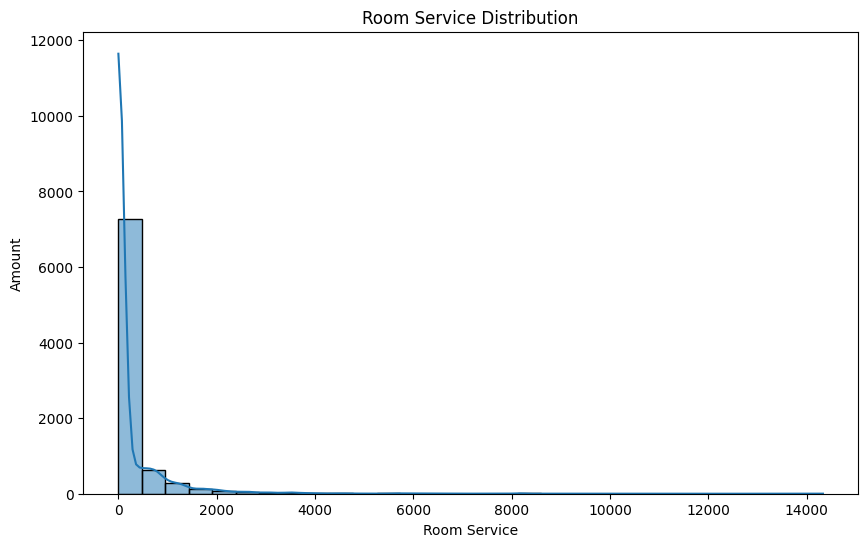

In [11]:
# Room Service
plt.figure(figsize=(10, 6))
sns.histplot(train_df['RoomService'].dropna(), bins=30, kde=True)
plt.title('Room Service Distribution')
plt.xlabel('Room Service')
plt.ylabel('Amount')
plt.show()


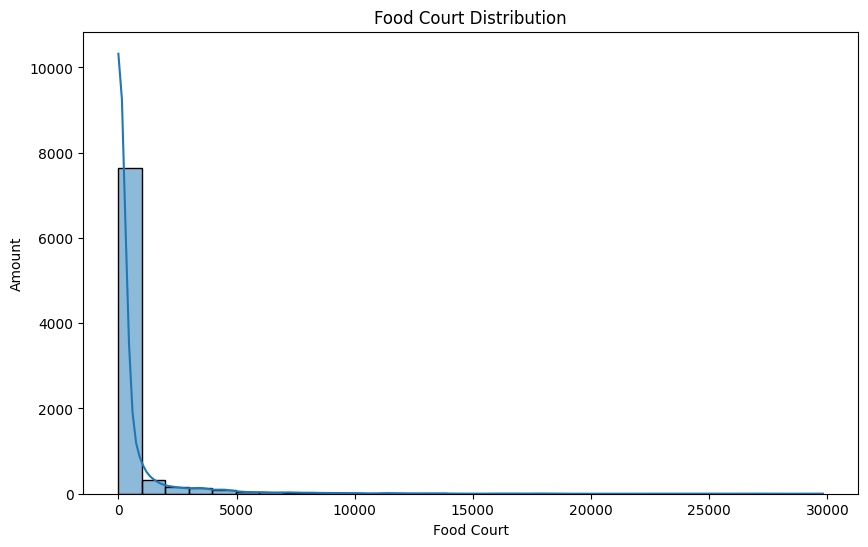

In [12]:
# Food Court
plt.figure(figsize=(10, 6))
sns.histplot(train_df['FoodCourt'].dropna(), bins=30, kde=True)
plt.title('Food Court Distribution')
plt.xlabel('Food Court')
plt.ylabel('Amount')
plt.show()


We will want to look at the breakdown of empty values by column to see where we are missing data and determine if it matters or not. 

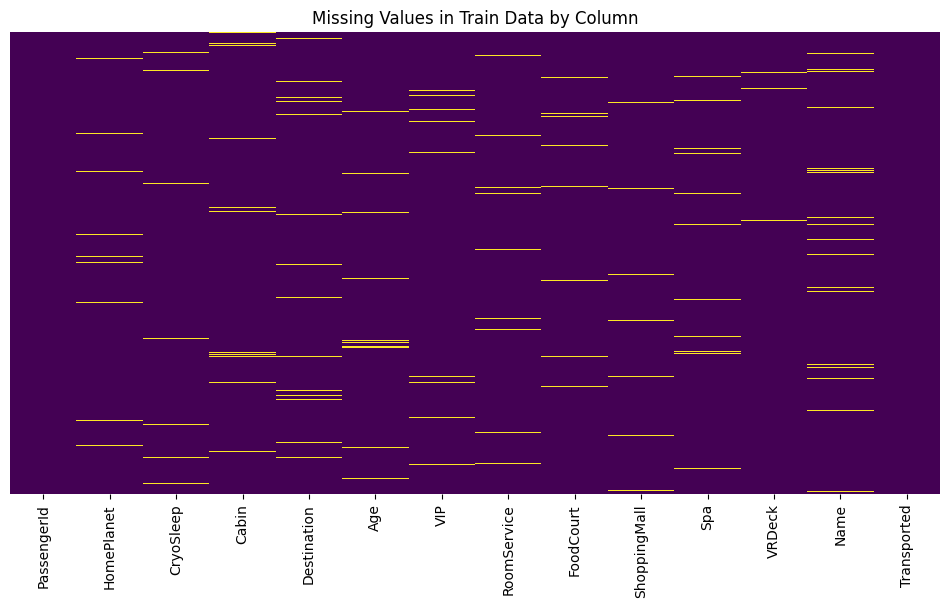

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in Train Data by Column')
plt.show()


In [14]:
null_counts = train_df.isnull().sum()
null_percent = train_df.isnull().mean() * 100
null_summary = pd.DataFrame({'Count': null_counts, 'Percent': null_percent})
print(null_summary.sort_values(by='Percent', ascending=False))

              Count   Percent
CryoSleep       217  2.496261
ShoppingMall    208  2.392730
VIP             203  2.335212
HomePlanet      201  2.312205
Name            200  2.300702
Cabin           199  2.289198
VRDeck          188  2.162660
Spa             183  2.105142
FoodCourt       183  2.105142
Destination     182  2.093639
RoomService     181  2.082135
Age             179  2.059128
PassengerId       0  0.000000
Transported       0  0.000000


Since all of the missing data is under 3% of the column total, we will use imputation to deal with the missing values. 

For numerical data, I'll use column median values to help mitigate outliers. For categorical data, I'll utilize a separate 'missing' value to account for these- I'll plan to change the boolean columns to string while treating like booleans with a third category. In addition, for numerical values I will incorporate a new column called '${column}_is_missing'. 

In [15]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [16]:

num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in num_cols:
    median_val = train_df[col].median()

    train_df.fillna({col: median_val}, inplace=True)

    train_df[f"{col}_is_missing"] = train_df[col].isnull().astype(int)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_is_missing,RoomService_is_missing,FoodCourt_is_missing,ShoppingMall_is_missing,Spa_is_missing,VRDeck_is_missing
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0,0,0,0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,0,0,0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,0,0,0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0,0,0,0,0,0


In [17]:
cat_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
train_df[cat_cols] = train_df[cat_cols].fillna('missing')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_is_missing,RoomService_is_missing,FoodCourt_is_missing,ShoppingMall_is_missing,Spa_is_missing,VRDeck_is_missing
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,0,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0,0,0,0,0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,0,0,0,0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,0,0,0,0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0,0,0,0,0,0


## Feature Engineering

Having looked at distribution of values in the different columns and dealt with missing fields, I'm going to move into a phase of creating new lower-level features from the high-level features we already have. These lower-level features will be: 
* group number - from passenger id
* number_within_group - from passenger_id
* deck - from cabin 
* num - from cabin
* side - from cabin
* age groups - create buckets for different age ranges
* high spender - based on total spend per row
* spending group - based on total spend per row
* last_name - from name

These will give us more granularity in the data which could help our models pinpoint significance in predictibility. 

In [18]:
train_df['group_number'] = train_df['PassengerId'].apply(lambda x: int(x.split('_')[0]))
train_df['number_within_group'] = train_df['PassengerId'].apply(lambda x: int(x.split('_')[1]))
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name,Transported,Age_is_missing,RoomService_is_missing,FoodCourt_is_missing,ShoppingMall_is_missing,Spa_is_missing,VRDeck_is_missing,group_number,number_within_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,Maham Ofracculy,False,0,0,0,0,0,0,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,Juanna Vines,True,0,0,0,0,0,0,2,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,Altark Susent,False,0,0,0,0,0,0,3,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,Solam Susent,False,0,0,0,0,0,0,3,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,Willy Santantines,True,0,0,0,0,0,0,4,1


In [19]:
train_df['cabin_deck'] = train_df['Cabin'].apply(lambda x: x.split('/')[0] if x != 'missing' else 'missing')
train_df['cabin_num'] = train_df['Cabin'].apply(lambda x: int(x.split('/')[1]) if x != 'missing' else -1)
train_df['cabin_side'] = train_df['Cabin'].apply(lambda x: x.split('/')[2] if x != 'missing' else 'missing')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,RoomService_is_missing,FoodCourt_is_missing,ShoppingMall_is_missing,Spa_is_missing,VRDeck_is_missing,group_number,number_within_group,cabin_deck,cabin_num,cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,0,0,0,0,1,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,0,0,0,0,2,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,0,0,0,0,3,1,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,0,0,0,0,3,2,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,0,0,0,0,0,4,1,F,1,S


In [20]:
train_df['age_decade'] = (train_df['Age'] // 10).astype(int)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,FoodCourt_is_missing,ShoppingMall_is_missing,Spa_is_missing,VRDeck_is_missing,group_number,number_within_group,cabin_deck,cabin_num,cabin_side,age_decade
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,0,0,0,1,1,B,0,P,3
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,0,0,0,2,1,F,0,S,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,0,0,0,3,1,A,0,S,5
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,0,0,0,3,2,A,0,S,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,0,0,0,0,4,1,F,1,S,1


In [21]:
train_df['total_spent'] = train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
train_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spent']].head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spent
0,0.0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0,736.0
2,43.0,3576.0,0.0,6715.0,49.0,10383.0
3,0.0,1283.0,371.0,3329.0,193.0,5176.0
4,303.0,70.0,151.0,565.0,2.0,1091.0


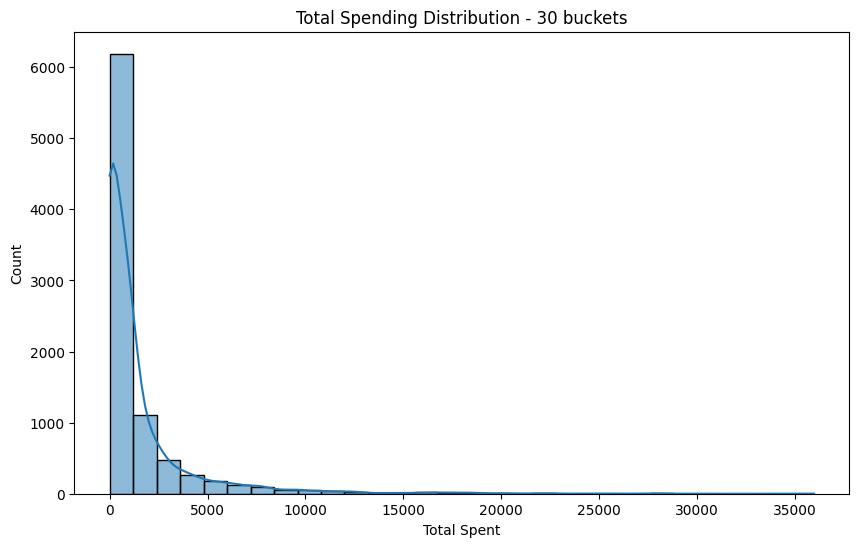

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_spent'], bins=30, kde=True)
plt.title('Total Spending Distribution - 30 buckets')
plt.xlabel('Total Spent')
plt.ylabel('Count')
plt.show()

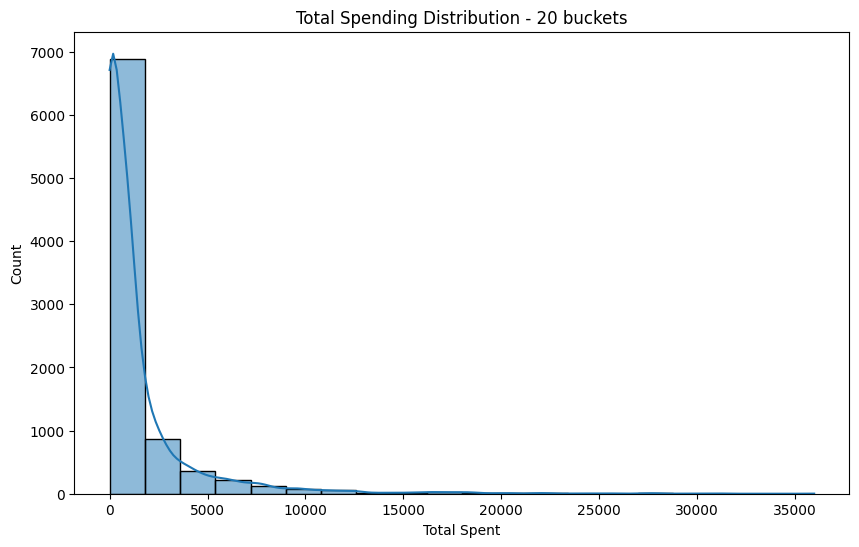

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['total_spent'], bins=20, kde=True)
plt.title('Total Spending Distribution - 20 buckets')
plt.xlabel('Total Spent')
plt.ylabel('Count')
plt.show()

In [24]:
bucket_counts = pd.cut(train_df['total_spent'], bins=20).value_counts(sort=False)
bucket_percent = (bucket_counts / len(train_df)) * 100
bucket_percent

total_spent
(-35.987, 1799.35]     79.190153
(1799.35, 3598.7]      10.054066
(3598.7, 5398.05]       4.095249
(5398.05, 7197.4]       2.484758
(7197.4, 8996.75]       1.495456
(8996.75, 10796.1]      0.851260
(10796.1, 12595.45]     0.598182
(12595.45, 14394.8]     0.218567
(14394.8, 16194.15]     0.195560
(16194.15, 17993.5]     0.276084
(17993.5, 19792.85]     0.184056
(19792.85, 21592.2]     0.080525
(21592.2, 23391.55]     0.080525
(23391.55, 25190.9]     0.034511
(25190.9, 26990.25]     0.034511
(26990.25, 28789.6]     0.069021
(28789.6, 30588.95]     0.023007
(30588.95, 32388.3]     0.023007
(32388.3, 34187.65]     0.000000
(34187.65, 35987.0]     0.011504
Name: count, dtype: float64

In [25]:
train_df['did_spend'] = (train_df['total_spent'] > 0).astype(int)
train_df['did_spend'].value_counts()

did_spend
1    5040
0    3653
Name: count, dtype: int64

In [26]:
train_df.loc[train_df['did_spend'] == 1, 'spending_quartile'] = pd.qcut(
    train_df.loc[train_df['did_spend'] == 1, 'total_spent'],
    q=4,
    labels=[1, 2, 3, 4]
).astype(int)
train_df['spending_quartile'] = train_df['spending_quartile'].fillna(0).astype(int)
train_df['high_spender'] = (train_df['spending_quartile'] == 4).astype(int)
train_df[['total_spent', 'spending_quartile', 'did_spend', 'high_spender']].head()

,total_spent,spending_quartile,did_spend,high_spender
0,0.0,0,0,0
1,736.0,1,1,0
2,10383.0,4,1,1
3,5176.0,4,1,1
4,1091.0,2,1,0


In [27]:
train_df['high_spender'].value_counts()

high_spender
0    7433
1    1260
Name: count, dtype: int64

In [28]:
train_df['last_name'] = train_df['Name'].str.split(' ').str[-1]
train_df['last_name'].value_counts().head(10)

last_name
Casonston     18
Oneiles       16
Domington     15
Litthews      15
Garnes        14
Browlerson    14
Fulloydez     14
Cartez        14
Gibbsonton    13
Distured      13
Name: count, dtype: int64

In [29]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Age_is_missing', 'RoomService_is_missing',
       'FoodCourt_is_missing', 'ShoppingMall_is_missing', 'Spa_is_missing',
       'VRDeck_is_missing', 'group_number', 'number_within_group',
       'cabin_deck', 'cabin_num', 'cabin_side', 'age_decade', 'total_spent',
       'did_spend', 'spending_quartile', 'high_spender', 'last_name'],
      dtype='object')

## Data Preprocessing

This section focuses on preparing data for use in model selection. This will involve some final cleaning as well as data splitting. 

- encoding categorical features
- scaling numerical features
- splitting data into training and testing sets

We will also look at our features to determine if there are any we can drop prior to use in model selection- the criteria for this will be specifically if there is any correlation between our given feature and whether that record was transported. 



In [30]:
train_df.dtypes

PassengerId                 object
HomePlanet                  object
CryoSleep                   object
Cabin                       object
Destination                 object
Age                        float64
VIP                         object
RoomService                float64
FoodCourt                  float64
ShoppingMall               float64
Spa                        float64
VRDeck                     float64
Name                        object
Transported                   bool
Age_is_missing               int64
RoomService_is_missing       int64
FoodCourt_is_missing         int64
ShoppingMall_is_missing      int64
Spa_is_missing               int64
VRDeck_is_missing            int64
group_number                 int64
number_within_group          int64
cabin_deck                  object
cabin_num                    int64
cabin_side                  object
age_decade                   int64
total_spent                float64
did_spend                    int64
spending_quartile   

We will want to create a mapping of sorts for features such as destination and home planet. 

For destination we will use the following mapping:
{
    TRAPPIST-1e: 1,
    55 Cancri e: 2,
    PSO J318.5-22: 3,
    missing: 4
}

For home planet we will use the following mapping:
{
    Earth: 1,
    Europa: 2,
    Mars: 3,
    missing: 4
}

In [31]:
destination_map = {
    'TRAPPIST-1e': 1,
    '55 Cancri e': 2,
    'PSO J318.5-22': 3,
    'missing': 4
}
train_df['destination_encoded'] = train_df['Destination'].map(destination_map)
train_df['destination_encoded'] = train_df['destination_encoded'].fillna(4).astype(int)
train_df = train_df.drop(columns=['Destination'])
train_df['destination_encoded'].value_counts()

destination_encoded
1    5915
2    1800
3     796
4     182
Name: count, dtype: int64

In [32]:
home_planet_map = {
    'Earth': 1,
    'Europa': 2,
    'Mars': 3,
    'missing': 4
}
train_df['home_planet_encoded'] = train_df['HomePlanet'].map(home_planet_map)
train_df['home_planet_encoded'] = train_df['home_planet_encoded'].fillna(4).astype(int)
train_df = train_df.drop(columns=['HomePlanet'])
train_df['home_planet_encoded'].value_counts()

home_planet_encoded
1    4602
2    2131
3    1759
4     201
Name: count, dtype: int64

There are several columns that are currently classified as objects but are really booleans. We will use a 1-0 system to adjust these. The specific columns are: 
- VIP
- CryoSleep

In [36]:
train_df['vip_encoded'] = train_df['VIP'].astype(bool).astype(int)
train_df['cryo_sleep_encoded'] = train_df['CryoSleep'].astype(bool).astype(int)
train_df[['VIP','vip_encoded', 'CryoSleep', 'cryo_sleep_encoded']].head()
train_df = train_df.drop(columns=['VIP', 'CryoSleep'])

There are several more columns we can drop as they have already been adjusted for use in model selection. 

These columns are: 
- PassengerId
- Cabin
- Name

In [37]:
train_df = train_df.drop(columns=['PassengerId', 'Cabin', 'Name'])

We will need to figure out a mapping for cabin_deck, last_name, and cabin_side. 

For cabin_side, we will simply use { P: 1, S: 2, missing: 3}

For last_name we will need to auto-increment values for each unique last_name. 

For cabin deck, we will use {
    A: 1,
    B: 2,
    C: 3, 
    D: 4,
    E: 5,
    F: 6,
    G: 7,
    T: 8,
    missing: 9
}

In [ ]:
ordered_last_names = sorted(train_df['last_name'].dropna().unique())
last_name_map = {name: idx + 1 for idx, name in enumerate(ordered_last_names)}
train_df['last_name_encoded'] = train_df['last_name'].map(last_name_map).fillna(0).astype(int)
train_df = train_df.drop(columns=['last_name'])
train_df['last_name_encoded'].head(10)

KeyError: "['last_name'] not in index"

In [41]:
cabin_deck_map = {
    'A': 1,
    'B': 2,
    'C': 3, 
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 8,
    'missing': 9
}
train_df['cabin_deck_encoded'] = train_df['cabin_deck'].map(cabin_deck_map)
train_df['cabin_deck_encoded'] = train_df['cabin_deck_encoded'].fillna(9).astype(int)
train_df = train_df.drop(columns=['cabin_deck'])
train_df['cabin_deck_encoded'].value_counts()

cabin_deck_encoded
6    2794
7    2559
5     876
2     779
3     747
4     478
1     256
9     199
8       5
Name: count, dtype: int64

In [43]:
cabin_side_map = {
    'P': 1,
    'S': 2,
    'missing': 3
}
train_df['cabin_side_encoded'] = train_df['cabin_side'].map(cabin_side_map)
train_df['cabin_side_encoded'] = train_df['cabin_side_encoded'].fillna(3).astype(int)
train_df = train_df.drop(columns=['cabin_side'])
train_df['cabin_side_encoded'].value_counts()

cabin_side_encoded
2    4288
1    4206
3     199
Name: count, dtype: int64

In [44]:
train_df.dtypes

Age                        float64
RoomService                float64
FoodCourt                  float64
ShoppingMall               float64
Spa                        float64
VRDeck                     float64
Transported                   bool
Age_is_missing               int64
RoomService_is_missing       int64
FoodCourt_is_missing         int64
ShoppingMall_is_missing      int64
Spa_is_missing               int64
VRDeck_is_missing            int64
group_number                 int64
number_within_group          int64
cabin_num                    int64
age_decade                   int64
total_spent                float64
did_spend                    int64
spending_quartile            int64
high_spender                 int64
last_name                   object
destination_encoded          int64
home_planet_encoded          int64
vip_encoded                  int64
cryo_sleep_encoded           int64
last_name_encoded            int64
cabin_deck_encoded           int64
cabin_side_encoded  